In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image

# Logistic Regression and Overfitting / Underfitting

Source: 

- RITHP, **Logistic Regression and regularization: Avoiding overfitting and improving generalization,** https://medium.com/@rithpansanga/logistic-regression-and-regularization-avoiding-overfitting-and-improving-generalization-e9afdcddd09d
- Nilesh Parashar, **From Generalization to Overfitting: The Science Behind Data Overfitting,** https://medium.com/@niitwork0921/from-generalization-to-overfitting-the-science-behind-data-overfitting-65f5c6901729
- Charles Chi, **Overfitting and Underfitting during Model Training,** https://medium.com/ai-assimilating-intelligence/overfitting-and-underfitting-in-model-training-e0b14a89bd49
- Ivan Zakharchuk, **Generalization, Overfitting, and Under-fitting in Supervised Learning,** https://ivanzakharchuk.medium.com/generalization-overfitting-and-underfitting-in-supervised-learning-a21f02ebf3df


#### Overfitting in logistic regression:

- Occurs when the model has too many parameters (degrees of freedom) relative to the size of the training data.
- Leads to high training accuracy but low test accuracy. 

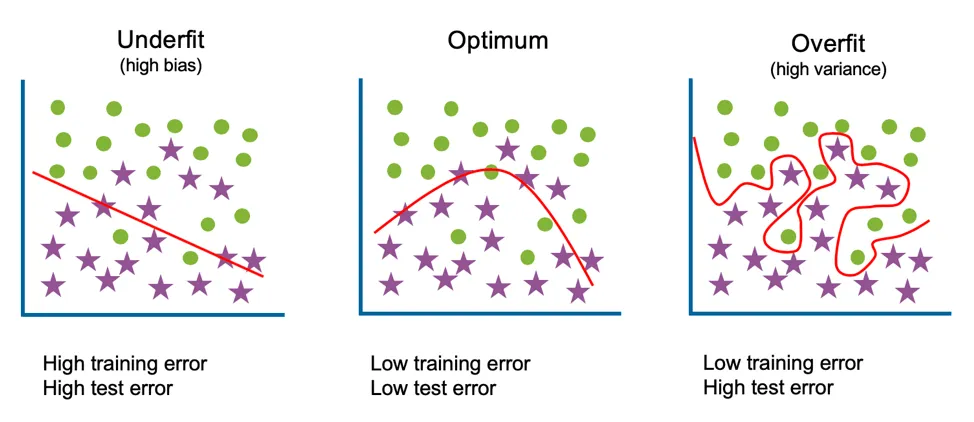

In [3]:
Image(filename="figures/regularization_1.png", width=800)

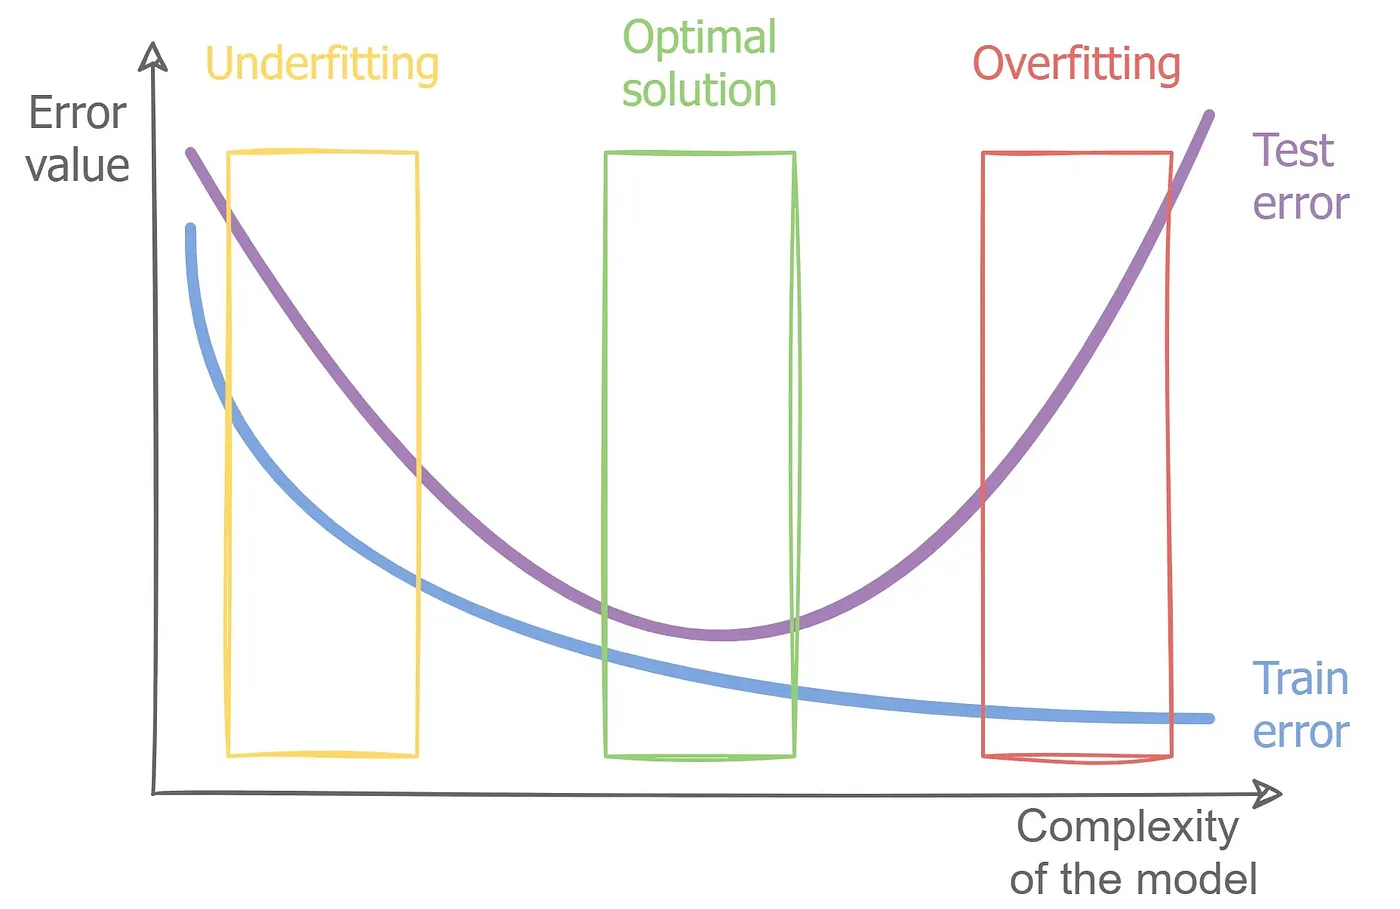

In [4]:
Image(filename="figures/regularization_2.png", width=500)

#### Regularization:

- Technique to avoid overfitting by adding a **penalty term** to the objective function (loss function) that the model is trying to minimize. 
- The penalty term **reduces the complexity of the model**.
- It improves its generalization by **reducing the variance** of the model.

#### Types of regularization:

- **L1 (Lasso)** regularization:
    * Adds a penalty term to the objective function equal to the absolute value of the coefficients.
    * Leads to a sparse model, where many of the coefficients are exactly equal to zero.
    * Useful for feature selection because it can automatically identify and remove unnecessary or redundant features.
      
- **L2 (Ridge)** regularization (default choice):
    * Adds a penalty term to the objective function equal to the square of the coefficients.
    * Leads to a model with all coefficients close to zero, but not necessarily equal to zero.
    * Less prone to overfitting than L1 regularization.
      
- **Elastic Net** regularization:
    * Combines L1 and L2 regularization by adding a penalty term that is a combination of the absolute value and square of the coefficients.
    * Leads to a model with some coefficients equal to zero and some close to zero.
    * Useful when there are correlated features in the data (Lasso is prone to selecting only one of them).

#### Regularization procedure:

- Choose strength of regularization (hyperparameter) via cross-validation.
- Select the hyperparameter that gives the best performance on the validation set. 
- Try a range of values (e.g. 10^-6 to 10⁶) and use a logarithmic scale. 
- Use a grid search to try a range of values for multiple hyperparameters at once.


**Other techniques:**

- **Feature selection and dimensionality reduction methods**: 
    * Extract the most important and useful traits while eliminating the rest. 

- **Ensemble techniques:**
    * Ensemble techniques like **bagging** and **boosting** integrate numerous models. 
    * Ensemble approaches improve generalization.
    * Mitigate the effect of individual model biases by combining the predictions of several models.
      
- **Boosting the size of the data used for training** and **simplifying the model**

- **Pruning (for decision trees):** 
    * Pruning reduces the size of decision trees by cutting off branches that have little importance, thus simplifying the model and reducing the risk of overfitting.

- **Dropout (for neural networks):**
    * Dropout randomly disables a fraction of neurons during training
    * Helps prevent the network from becoming overly dependent on any specific set of features, i.e. helps generalize.

#### How to implement logistic regression with regularization in python:

- Use the `LogisticRegression` class in `scikit-learn` with the **“penalty”** and **“C”** hyperparameters

- Set the **“penalty”** hyperparameter to **“l1”, “l2”,** or **“elasticnet”.**

- Set the **“C”** hyperparameter to the regularization strength.

- The “C” hyperparameter controls the strength of the regularization:
    * A smaller value for “C” (e.g. C=0.01) leads to stronger regularization and a simpler model.
    * A larger value (e.g. C=1.0) leads to weaker regularization and a more complex model.

#### Example:

In [5]:
import itertools
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [6]:
df_churn_pd = pd.read_csv("/data/IFI8410/sess09/mergedcustomers_missing_values_GENDER.csv")
df_churn_pd.head()

,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,1703,Medium,NaN,M,2,28766.9,N,47,6110.61,58,1527.6525,152.76525,8.70,2,13,0.0000,152.76525
1,1704,Low,NaN,M,2,91272.2,Y,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,1705,Low,NaN,S,0,73228.3,N,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,1706,High,M,M,1,64792.3,N,52,13051.31,36,6525.6550,652.56550,9.00,3,6,0.0000,652.56550
4,1707,High,F,S,0,93322.1,Y,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,0.0000,1496.14950


In [7]:
#remove columns that are not required
df_churn_pd = df_churn_pd.drop(['ID'], axis=1)

In [8]:
# Defining the categorical columns 
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER']

print("Categorical columns : " )
print(categoricalColumns)

impute_categorical = SimpleImputer(strategy="most_frequent")
onehot_categorical =  OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('impute',impute_categorical),('onehot',onehot_categorical)])

Categorical columns : 
['GENDER', 'STATUS', 'HOMEOWNER']


In [9]:
# Defining the numerical columns 
numericalColumns = df_churn_pd.select_dtypes(include=[float,int]).columns

print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale',scaler_numerical)])

Numerical columns : 
Index(['CHILDREN', 'ESTINCOME', 'AGE', 'TOTALDOLLARVALUETRADED',
       'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION',
       'SMALLESTSINGLETRANSACTION', 'PERCENTCHANGECALCULATION',
       'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD',
       'NETREALIZEDLOSSES_YTD'],
      dtype='object')


In [10]:
preprocessorForCategoricalColumns = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categoricalColumns)],
    remainder="passthrough")

preprocessorForAllColumns = ColumnTransformer(
    transformers=[
    ('cat', categorical_transformer, categoricalColumns),
    ('num', numerical_transformer, numericalColumns)
    ], remainder="passthrough")

In [11]:
# The transformation happens in the pipeline. Temporarily done here to show what intermediate value looks like
df_churn_pd_temp = preprocessorForCategoricalColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp)

df_churn_pd_temp_2 = preprocessorForAllColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp_2)

Data after transforming :
[[1.0 0.0 0.0 ... 13 0.0 152.76525]
 [1.0 0.0 0.0 ... 10 1349.635 0.0]
 [1.0 0.0 0.0 ... 5 1123.6125 0.0]
 ...
 [1.0 0.0 0.0 ... 11 0.0 82.50825]
 [1.0 0.0 0.0 ... 5 930.093 0.0]
 [0.0 1.0 0.0 ... 8 1041.604 0.0]]
Data after transforming :
[[1.0 0.0 0.0 ... -0.6792731303453047 -0.5106065181930338 'Medium']
 [1.0 0.0 0.0 ... 1.8354629319820521 -0.7959345330293706 'Low']
 [1.0 0.0 0.0 ... 1.4143217110983428 -0.7959345330293706 'Low']
 ...
 [1.0 0.0 0.0 ... -0.6792731303453047 -0.6418293606808149 'Medium']
 [1.0 0.0 0.0 ... 1.053742394902809 -0.7959345330293706 'Low']
 [0.0 1.0 0.0 ... 1.261517632686496 -0.7959345330293706 'Low']]


In [12]:
# prepare data frame for splitting data into train and test datasets
features = []
features = df_churn_pd.drop(['CHURNRISK'], axis=1)

label_churn = pd.DataFrame(df_churn_pd, columns = ['CHURNRISK']) 

df_churn_pd.loc[df_churn_pd['CHURNRISK'] == 'Medium', 'CHURNRISK'] = 'High'

label_encoder = LabelEncoder()
label = df_churn_pd['CHURNRISK']

label = label_encoder.fit_transform(label)
print("Encoded value of Churnrisk after applying label encoder : " + str(label))

Encoded value of Churnrisk after applying label encoder : [0 1 1 ... 0 1 1]


In [13]:
# Load the data
X = features
y = label

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### L1 regularization

In [14]:
penalty="l1"
solver="liblinear"
    
# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=0.01
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=0.1
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=1.0
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.99
Test accuracy: 0.99
Test accuracy: 0.99


/usr/local/lib64/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### L2 regularization

In [15]:
penalty="l2"
solver="liblinear"
    
# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=0.01
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=0.1
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=1.0
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.99
Test accuracy: 0.99
Test accuracy: 0.99


#### Elastic net regularization

In [16]:
penalty="elasticnet"
solver="saga"
    
# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    l1_ratio=0.5,
    C=0.01,
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    l1_ratio=0.5,
    C=0.1,
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

# Create a logistic regression model
logisticRegressionClassifier = LogisticRegression(
    penalty=penalty,
    solver=solver,
    l1_ratio=0.5,
    C=1.0,
)

model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                        ('classifier', logisticRegressionClassifier)]) 

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.99
Test accuracy: 0.99
Test accuracy: 0.99


/usr/local/lib64/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib64/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib64/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Underfitting:

- **Increase Model Complexity:** 
    * A more complex model is necessary to capture the nuances of your data.
    * Add more layers to a neural network.
    * Use a more sophisticated algorithm to learn more complex patterns.

- F**eature Engineering:** 
    * Improve model performance by creating new features.
    * The right features can be transformations which better highlight the relationships between variables. 

- **Reduce Regularization:**
    * Reduce the strength of regularization.

- **Increase Training Time:**
    * Allow more time for training.
    * Run more epochs or iterations.
    * Giving the model additional opportunities to learn from the data. Related: tweaking learning rate may help as well.

- **Add More Data:**
    * If feasible, incorporate more training data to help the model to identify and learn the underlying structure of the dataset. 
    * More data provides a broader representation of the problem space, potentially improving the model’s accuracy and generalization.

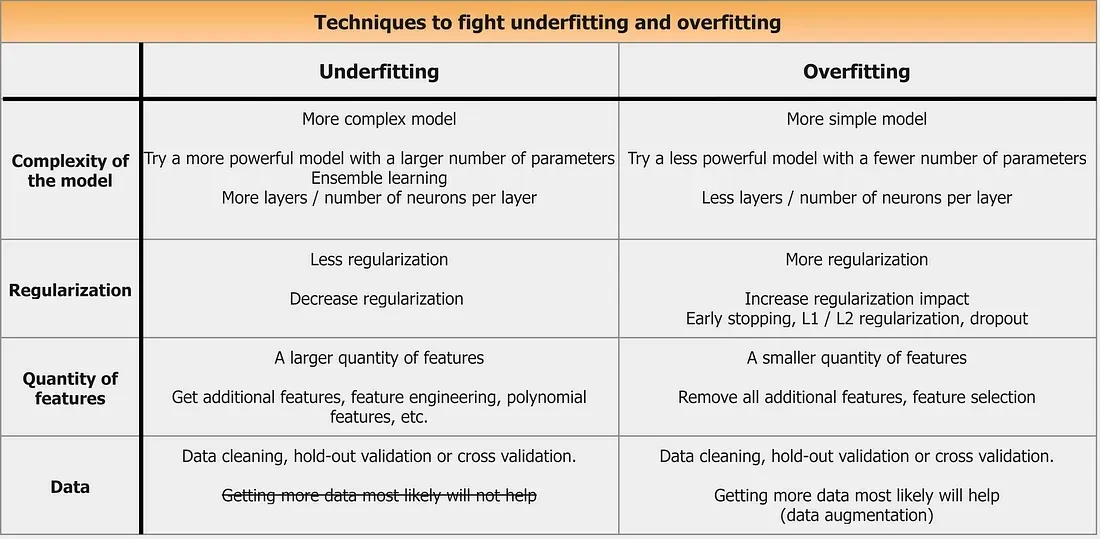

In [17]:
Image(filename="figures/regularization_3.png", width=800)

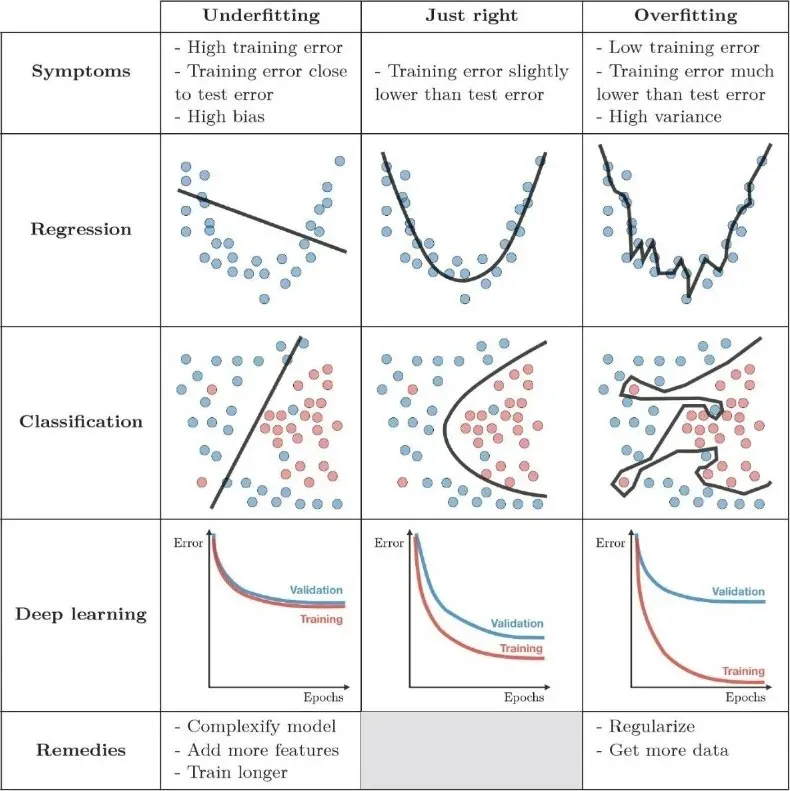

In [18]:
Image(filename="figures/regularization_4.png", width=800)